<a href="https://colab.research.google.com/github/youtlh/DeepLearningPytorch/blob/main/P1Ch5_6_Learning_mechanics_and_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Mechanics

In [1]:
import torch

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # ground truth
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # observations
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [2]:
# build a simple linear model with two parameters to fit, w and b
def model(t_u, w, b):
  return w * t_u + b

In [3]:
# initialize the tensor for parameters
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

## Loss and Gradient

In [4]:
# simple mean square error loss function
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

In [5]:
# compute the loss
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [6]:
# estimate the rate of change (local derivative) by adding a small number to w and b and seeing how much the loss changes in that neighborhood
# shift the parameter by derivative * learning rate
delta = 0.1
learning_rate = 1e-2

loss_rate_of_change_w = \
  (loss_fn(model(t_u, w + delta, b), t_c) -
  loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = \
  (loss_fn(model(t_u, w, b + delta), t_c) -
  loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

In [7]:
# to compute the derivative analytically dx^2/dx = 2x
def dloss_fn(t_p, t_c):
  dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # division comes from the derivative of mean
  return dsq_diffs

In [8]:
# applying the derivatives to the model
def dmodel_dw(t_u, w, b):
  return t_u

def dmodel_db(t_u, w, b):
  return 1.0

In [9]:
# Define the gradient function
def grad_fn(t_u, t_c, t_p, w, b):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
  return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [10]:
# Define the iterative training loop
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    w, b = params

    t_p = model(t_u, w, b) # forward pass
    loss = loss_fn(t_p, t_c)
    grad = grad_fn(t_u, t_c, t_p, w, b) # backward pass

    params = params - learning_rate * grad
    print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params

In [11]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # backward pass

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [12]:
training_loop(
  n_epochs = 100,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 0.0]),
  t_u = t_u,
  t_c = t_c)
# training blow up due to large learning rate

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

In [13]:
training_loop(
  n_epochs = 100,
  learning_rate = 1e-4,
  params = torch.tensor([1.0, 0.0]),
  t_u = t_u,
  t_c = t_c)
# reduce learning rate, behaviour stable
# however because update are small, loss decreases very slowly and evantualy stalls
# note that the gradient for w is much larger than that for b

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [14]:
# normalize the gradient, instead of setting up different learning rate for different parameter, we change the inputs so that the gradients aren't quite so different.
# why this normalization works? need to keep the range of input within range of -1.0 to 1.0.
t_un = 0.1 * t_u
training_loop(
  n_epochs = 100,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 0.0]),
  t_u = t_un,
  t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [15]:
# increase the number of epoch
params = training_loop(
  n_epochs = 5000,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 0.0]),
  t_u = t_un,
  t_c = t_c)

params

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])
Epoch 5000, Loss 2.927648
    Params: tensor([  5.3671, -17.3012])
    Grad:   tensor([-0.0001,  0.0006])


tensor([  5.3671, -17.3012])

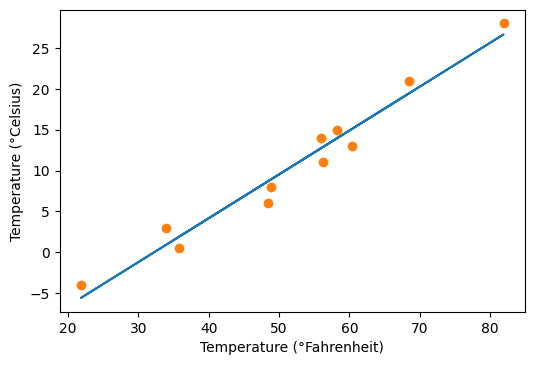

In [16]:
# visualize the data
%matplotlib inline
from matplotlib import pyplot as plt
t_p = model(t_un, *params) # *params: argument unpacking, will pass the elements of params as individual arguments
fig = plt.figure(dpi=100)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

## Backpropagation

In [17]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
# requires_grad tells pytorch to track the entire family tree of tensors resulting from operations on params.

In [18]:
params.grad is None
# normally the .gard attribute is None

True

In [19]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward() # this will calcualte the derivatives using autograd
params.grad

tensor([4517.2969,   82.6000])

In [20]:
# NOTE! every time after we compute the derivative using backward, we need to zero the gradient explicitly at each iteration to avoid the derivatives accumulate at leaf nodes.
if params.grad is not None:
  params.grad.zero_()

In [21]:
# combining the autogard into training loop coding
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    if params.grad is not None: # this should be done any point in the loop prior to calling loss.backward()
      params.grad.zero_()
    
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
    loss.backward()

    with torch.no_grad():
      params -= learning_rate * params.grad
    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params

In [22]:
training_loop(
  n_epochs = 5000,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 0.0], requires_grad=True), # make sure we are calculating the gradient
  t_u = t_un,
  t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimization

Every optimizer constructor takes a list of parameters as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their grad attribute.

Each optimizer exposes two methods: .zero_grad() and .step().
.zero_grad() zeroes the grad attribute of all the parameters passed to the optimizer upon construction. .step() updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

In [23]:
# different optimization methods provided by pytorch
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [24]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)
# stochastic gradient descent is the vanilla gradient descent.
# the word stochastic comes from the fact that the gtradient is typically obtained by averaging over a random subset of all input samples called minibatch.

In [25]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [26]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # always need to zeroes out previous gradient anywhere in the loop earlier than the .backward()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [27]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params

In [28]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # important that this params

training_loop(
  n_epochs = 5000,
  optimizer = optimizer,
  params = params,  # and this params are the same object, otherwise the model don't know what to optimize
  t_u = t_un,
  t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [29]:
# trying using different optimization function
# Adam is more sophisticated optimizier and the learning rate is set adaptively.
# It is less sensitive to the parameter scaling, so that we can use the original t_u rather than t_un
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
  n_epochs = 2000,
  optimizer = optimizer,
  params = params,
  t_u = t_u,
  t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

## Train, Validation and Overfitting

In [30]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples) # generate a random permutation of the tensor elements

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([5, 1, 7, 2, 8, 6, 9, 0, 3]), tensor([ 4, 10]))

In [31]:
# building the training and validation set using the random index
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [32]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
  for epoch in range(1, n_epochs + 1):
    train_t_p = model(train_t_u, *params)
    train_loss = loss_fn(train_t_p, train_t_c)

    val_t_p = model(val_t_u, *params) 
    val_loss = loss_fn(val_t_p, val_t_c) # calculate the loss for validation to monitor the progress

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    # no val_loss.backward() since we don't want to train the model on the validation set

    if epoch <= 3 or epoch % 500 == 0:
      print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            f" Validation loss {val_loss.item():.4f}")
  return params

In [33]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
  n_epochs = 3000,
  optimizer = optimizer,
  params = params,
  train_t_u = train_t_un,
  val_t_u = val_t_un, 
  train_t_c = train_t_c,
  val_t_c = val_t_c)

Epoch 1, Training loss 72.7406, Validation loss 114.6712
Epoch 2, Training loss 40.2682, Validation loss 46.4569
Epoch 3, Training loss 33.9582, Validation loss 27.9884
Epoch 500, Training loss 7.0645, Validation loss 6.8510
Epoch 1000, Training loss 3.4611, Validation loss 4.2858
Epoch 1500, Training loss 2.9574, Validation loss 3.5832
Epoch 2000, Training loss 2.8870, Validation loss 3.3564
Epoch 2500, Training loss 2.8772, Validation loss 3.2767
Epoch 3000, Training loss 2.8758, Validation loss 3.2475


tensor([  5.2908, -16.8837], requires_grad=True)

In [34]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
  for epoch in range(1, n_epochs + 1):
    train_t_p = model(train_t_u, *params)
    train_loss = loss_fn(train_t_p, train_t_c)

    with torch.no_grad():
      val_t_p = model(val_t_u, *params)
      val_loss = loss_fn(val_t_p, val_t_c)
      assert val_loss.requires_grad == False # manually switch off grad calculation for validation set

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

In [35]:
def calc_forward(t_u, t_c, is_train): # alternatively, we could also pass in whether to construct the autograd as parameter
  with torch.set_grad_enabled(is_train):
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
  return loss

# Using NN network

Pytorch has a whole submodule dedicated to neural networks, called torch.nn. It contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modulus (layers in other frameworks).

In [40]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [41]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  3,  7,  6,  8,  5, 10,  4,  9]), tensor([2, 0]))

In [42]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [47]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # the number of input features, and number of output features. There's a potential key, whether the linear model includes a bias or not, default is True
linear_model(t_un_val)

tensor([[ 0.0682],
        [-0.2397]], grad_fn=<AddmmBackward0>)

Calling any module (layer) from nn.Module is equal to calling a method named forward in that module. It executes the forward computation.

In [49]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.1369]], requires_grad=True), Parameter containing:
 tensor([-0.7284], requires_grad=True))

In [50]:
linear_model(torch.ones(1))

tensor([-0.5915], grad_fn=<AddBackward0>)

## Model design and optimization

In [51]:
import torch.optim as optim

linear_model = nn.Linear(1,1)
optimizer = optim.SGD(
  linear_model.parameters(), # replaces [params]
  lr=1e-2
)

In [52]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7073]], requires_grad=True), Parameter containing:
 tensor([-0.2451], requires_grad=True)]

In [54]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
  for epoch in range(1, n_epochs+1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_u_val)
    loss_val = loss_fn(t_p_val, t_c_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch%1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
            f" Validation loss {loss_val.item():.4f}")

In [58]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

linear_model.weight, linear_model.bias

Epoch 1, Training loss 309.9214, Validation loss 179.2974
Epoch 1000, Training loss 3.9721, Validation loss 4.2551
Epoch 2000, Training loss 3.2314, Validation loss 2.1787
Epoch 3000, Training loss 3.2099, Validation loss 1.9104


(Parameter containing:
 tensor([[5.2384]], requires_grad=True), Parameter containing:
 tensor([-16.5808], requires_grad=True))

## Sequencing the model

In [61]:
# nn provides a simple way to concatenate models
seq_model = nn.Sequential(
    nn.Linear(1, 13), # this number is arbitrary
    nn.Tanh(),
    nn.Linear(13, 1) # as long as this number match the previous one
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [64]:
[param.shape for param in seq_model.parameters()]
# once model.backward() is called, all the parameter will get their derivatives
# optimizers will then updates their values accordingly during optimizer.step()

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [65]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [66]:
# name the submodules to better differentiate them
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1,8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [67]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [70]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 1.5545, Validation loss 4.4465
Epoch 1000, Training loss 1.5154, Validation loss 3.7678
Epoch 2000, Training loss 1.4892, Validation loss 4.0569
Epoch 3000, Training loss 1.4676, Validation loss 4.2991
Epoch 4000, Training loss 1.4495, Validation loss 4.5063
Epoch 5000, Training loss 1.4342, Validation loss 4.6859
output tensor([[12.6090],
        [ 2.8929]], grad_fn=<AddmmBackward0>)
answer tensor([[15.0000],
        [ 0.5000]])
hidden tensor([[ 0.1569],
        [ 0.1680],
        [-0.2100],
        [ 7.9316],
        [ 0.1618],
        [ 8.2613],
        [ 7.8252],
        [-8.3325]])


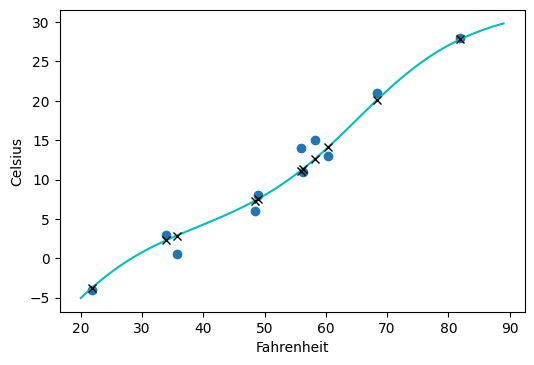

In [72]:
# visualize and compare with linear model
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')